In [1]:
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm

import os
import sys
sys.path.append('..')
from tqdm import tqdm
from datetime import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from src.support_function import *
import warnings
# warnings.filterwarnings('ignore')

In [2]:
root_1 = '../Dataset'
df_ori = pd.read_csv(os.path.join(root_1, '3bs_8q_4p_test_resid.csv'),
                parse_dates=['datetime'])
df_train = pd.read_csv(os.path.join(root_1, '3bs_8q_4p_train_resid.csv'),
                parse_dates=['datetime'])
# Column names for all sensors
columns = ['q'+str(i) for i in range(1,12)] + ['p'+str(j) for j in range(1,8)]

In [3]:
df_ori.head(2)

,datetime,p1,p2,p3,p4,p5,p6,p7,q1,q10,...,q4,q5,q6,q7,q8,q9,q8_seasonal,q8_ori,p5_seasonal,p5_ori
0,2019-01-01 00:30:00,-0.208963,-0.226402,-0.083406,-0.139544,-0.335937,0.041241,0.016622,-0.049463,-0.018966,...,-0.049428,0.038180,0.016469,-0.028413,-0.004576,-0.002180,-0.062410,0.224880,-0.033273,0.372107
1,2019-01-01 01:00:00,0.022636,0.020021,-0.098132,-0.036963,-0.001460,0.126563,0.028108,-0.020315,-0.002354,...,-0.007227,0.035003,0.014642,-0.027348,-0.018031,-0.023899,-0.039385,0.167464,-0.000815,0.369831


In [7]:
# The training set is used for training the VAR model
# The valid set is only for predict and valid
model = ARMA(df_train['q8'].interpolate().fillna(0).values,
            order=(3,2))
# hist_lag = 48*3
model_fitted = model.fit()

In [7]:
dataset = df_train['q8'].interpolate().fillna(0).iloc[:2000].values
model2 = sm.tsa.ARMA(dataset[:1500],
            order=(1,1)).fit()

out = model2.predict(start=1500, end=1500)
#                      , exog=dataset[1509:1519])
print(out)
pa = model2.params

[0.00552074]


In [9]:
pa[0]*dataset[1499] + pa[2] + pa[1]

-0.11092243278638847

In [8]:
model_fitted.params

array([ 1.40904301e-06,  1.78857447e+00, -8.89271823e-01,  4.53111942e-02,
       -1.72987649e+00,  7.40593218e-01])

In [15]:
model_fitted.k_trend
model.k_trend

AttributeError: 'ARMA' object has no attribute 'k_trend'

In [18]:
df = df_ori.interpolate().fillna(0).copy()
train_size = 48*7
future_lag = 4
station_for_pred = 'q8'
timestamp_list = []
resid_pred_list = []
for i in tqdm(range(0, df.shape[0]-train_size-future_lag)):
#     try:
    inputs = df['q8'].iloc[i:i+train_size].values
    model = sm.tsa.ARMA(df['q8'].iloc[i:i+train_size].values,
                order=(2,2)).fit()
#     model.k_trend = 1
    #     model.fit()
    #     forecast_input = df[columns].copy().values[i: i+hist_lag]
    forecast_timestamp = datetime.timestamp(df['datetime'].iloc[i+train_size])
    forecast_output = model.predict(params=model_fitted.params, start=train_size, end=train_size+future_lag-1)
    #     df['pred_arima_lag1'].iloc[index+train_size] = pred[0]
    #     df_test['pred_arima_lag2'].iloc[index+train_size+1] = pred[1]
    #     df_test['pred_arima_lag3'].iloc[index+train_size+2] = pred[2]
    #     df_test['pred_arima_lag4'].iloc[index+train_size+3] = pred[3]

        
    resid_pred_list += [forecast_output]
#     except:
#     resid_pred_list += [np.nan, np.nan, np.nan, np.nan]
#     print('error', i)
    timestamp_list += [forecast_timestamp]

  0%|                                                                          | 0/4153 [00:00<?, ?it/s]


TypeError: predict() got an unexpected keyword argument 'params'

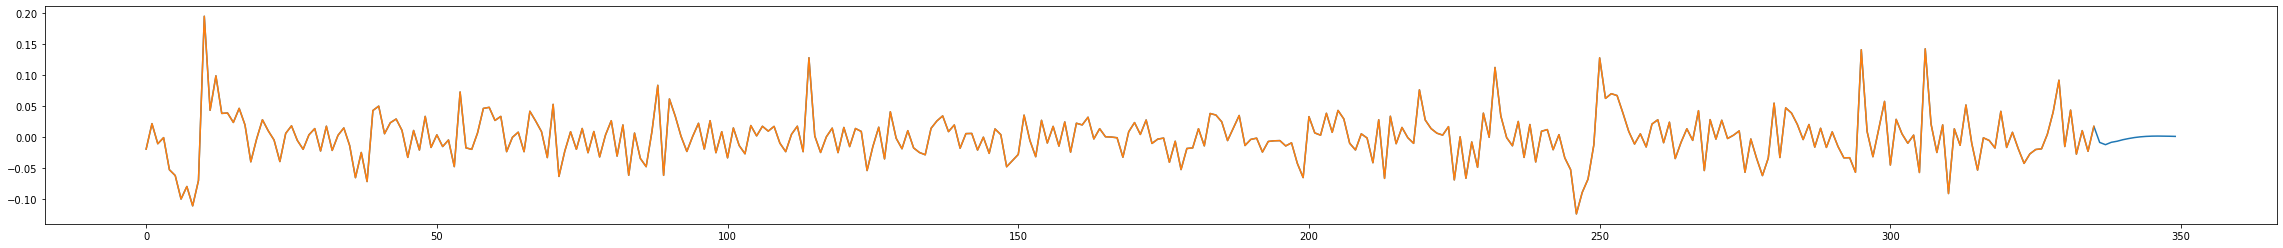

In [43]:
plt.figure(figsize=(40,4))
plt.plot(list(inputs) + list(forecast_output))
plt.plot(inputs)
# plt.plot(forecast_output)
plt.show()

In [49]:
timestamp_list
resid_pred_list[0]
list(forecast_output)
model.params

array([-7.24517761e-05, -2.80801922e-01,  7.19193673e-01, -2.89434643e-08,
       -9.99999971e-01])

In [47]:
df1 = pd.read_csv(os.path.join('../Dataset', '3bs_8q_4p_test_resid.csv'),
                     parse_dates=['datetime'])
df1.index = df1['datetime'].apply(datetime.timestamp)
resid_columns = ['resi1', 'resi2', 'resi3', 'resi4']
df2 = pd.DataFrame(np.array(resid_pred_list), index=np.array(timestamp_list), columns=resid_columns)
df3 = df1.join(df2)
start = 200
# end = -20
end=400
df3['temp'] = 0
df3['0'] = 0
mean_mse = 0
mean_mae = 0
for index, i in enumerate(resid_columns):
    df3['temp'] += df3[i].copy()
    df3['pre_'+ i] = (df3['temp'] + df3['q8_seasonal'].shift(-index).rolling(index+1).sum() + 
                      df3['q8_ori'].copy().shift(-1)).shift(index)
    eval_dict = eval_metrics(df3['pre_' + i].iloc[start:end].values, df3['q8_ori'].iloc[start:end].values)
    print(eval_dict)
    mean_mae += eval_dict['MAE']/4
    mean_mse += eval_dict['MSE']/4
print('mae', mean_mae, 'mse', mean_mse)

print()
print(eval_metrics(df3['resi1'].shift(0).iloc[start:-20].values, df3['q8'].iloc[start:-20].values))
print(eval_metrics(df3['resi2'].shift(1).iloc[start:-20].values, df3['q8'].iloc[start:-20].values))
print(eval_metrics(df3['resi4'].shift(3).iloc[start:-20].values, df3['q8'].iloc[start:-20].values))
print(eval_metrics(df3['0'].iloc[start:-20].values, df3['q8'].iloc[start:-20].values))

def plot_series(df_list, start, end):
    length = df_list[0].iloc[start: end].shape[0]
    plt.figure(figsize=(int(length/20),4), 
               facecolor='w')
    for i in df_list:
        i.iloc[start: end].plot()
    plt.legend([i.name for i in df_list])
    plt.show()
    
plot_series([df3['q8_ori'], df3['pre_resi1'], df3['pre_resi4']], start, end)
plot_series([df3['q8'], df3['resi4'].shift(3)], start, 300)

ValueError: Shape of passed values is (7840, 1), indices imply (4345, 4)